# ISMT S-117 |  Text Analytics Final Project 

#### Project Members:
- Praneet Singh Solanki (prs184@g.harvard.com)
- Emmanuel Awa (ema142@g.harvard.com)

## Article Classification of the Microsoft MIND Dataset - Evaluation of various NLP approaches   


### Overview

We explore various NLP approaches learned in class, gained from work and general research. We apply these knowledge to Sequence Classification, specifically news article classification using the [Microsoft MIND dataset](https://blogs.msn.com/mind-at-work-news-recommendation-challenge-for-researchers/) from the on-going compettion. 

Here is an excerpt describing [MIND](https://blogs.msn.com/mind-at-work-news-recommendation-challenge-for-researchers/) - Recommendation engines try to discern habits, likes and other affinity traits to anticipate what you may need or want based on past actions. News consumption can fall into these patterns: We know for instance that people go to search engines to find out more about a story, be it more background or further developments. Certain types of news and feature stories lend itself to typical user behaviors: An impending hurricane, for instance, triggers preparation research (if you’re in the path), offers of help to donate supplies or blood (if you’re nearby) and historical curiosity of past hurricanes. Even celebrity stories inspire certain common impulses: An engagement announcement will launch some to seek a peek at the ring, others to check out past (failed) relationships.

How might a news recommendation system offer more stories, yet not fall into the trap of filter bubbles and echo chambers? The first thing is, you need a high-quality benchmark dataset. That’s where MIND comes in: a mammoth collection of anonymized data from user behavior logs of about 1 million people. Few companies in the world attract those kinds of numbers, and Microsoft News is one of them.  

The goal of this project is to experiment, evaluate and build the news/article classification pipeline that can be leveraged ina news recommendation engine.  The recommendation engine is out of scope for this project, due to the limited timeframe, but is our north star for future work that we intend to do 


### Data Source   

The MIND datasets are stored in the West/East US data centers making it readily available, geographically, for anyone that is interested in participating in the competition.  


### NLP Techniques Summary 

We applied our learnings from the class, experimenting and reporting the different NLP approaches. Below is a summary of what this notebook covers. Details will be expanded upon as we go along. 

1. Tokenization strategies  

1. Vectorization using CountVectorization, TfIdfVectorization  

1. Topic Modelling using NMF and LDA  

1. Larger context vectorization using GloVE and using Multiple Transformer Models  


In [6]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%autoreload 2

## Import requirements

In [8]:
# setup
import sys
import subprocess
import pkg_resources
from collections import Counter
import re

required = {'scikit-learn', 'numpy', 'scrapbook',
            'pandas', 'matplotlib',
            'transformers==2.10.0'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)


In [9]:
import json
import os
import pickle
import shutil
import sys
import tempfile
import urllib
import zipfile
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import scrapbook as sb
import torch
import torch.nn as nn
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from spacy.lang.en import English
from tqdm import tqdm

# Our code components
from common.article_classification_dataset import (
    ArticleClassificationDataProcessor,
    ArticleClassificationDataSet,
)
from common.article_classification_model import ArticleClassifier
from common.article_classification_utilities import DownloadMindDataset, Timer
from common.plots import pca_plots

In [10]:
!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()
en = English()

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [11]:
# notebook parameters
CACHE_DIR = TemporaryDirectory().name
NUM_EPOCHS = 1
BATCH_SIZE = 32
NUM_GPUS = torch.cuda.device_count()
MAX_LEN = 100
MODEL_NAMES = ["distilbert-base-uncased", "roberta-base", "xlnet-base-cased"]
MODEL_RESULTS = dict()
LABEL_COL = "category"
TEXT_COL = "text"

### Running a sample of the data quickly  

We've have provided a flag `QUICK_RUN` that is set to `True` by default. This will create a smaller subset of both the training and test datasets to enable a fast evaluation.  

> **NOTE**: Running with `QUICK_RUN = True` may not guarantee the best results, especially for the transfomer models that thrive on more data during training.  

In [12]:
QUICK_RUN = True
TRAINING_FRAC = 1
TEST_FRAC = 1

if QUICK_RUN:
    TRAINING_FRAC = 0.2
    TEST_FRAC = 0.2

## Read the files with pandas  
 The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
 It has 7 columns, which are divided by the tab symbol:
 - News ID
 - Category
 - Subcategory
 - Title
 - Abstract
 - URL
 - Title Entities (entities contained in the title of this news)
 - Abstract Entities (entities contained in the abstract of this news)

### Download and Process MIND Dataset  

Using `DownloadMindDataset.process_and_load_dfs()` returns the training and test dataframes.  

> - Using defaults sets the data directory to `mind_dataset` and downloads small set
> - If the data is already downloaded, the download process is skipped


In [13]:
df_train, df_test = DownloadMindDataset.process_and_load_dfs()

Bypassing download of already-downloaded file MINDsmall_train.zip
Bypassing download of already-downloaded file MINDsmall_dev.zip
Train:  ['entity_embedding.vec', 'https_mind201910small.blob.core.windows.net_release_MINDsmall_train.zip', 'relation_embedding.vec', 'news.tsv', 'behaviors.tsv']
Test:  ['entity_embedding.vec', 'relation_embedding.vec', 'news.tsv', 'behaviors.tsv', 'https_mind201910small.blob.core.windows.net_release_MINDsmall_dev.zip']


In [14]:
display(df_train.head())
display(df_train.head())

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [15]:
display(df_train.shape)
display(df_test.shape)

(51282, 8)

(42416, 8)

## Functions

## Introduction
In this notebook, we fine-tune and evaluate a number of pretrained models on a subset of the [Microsoft MIND Dataset](https://blogs.msn.com/mind-at-work-news-recommendation-challenge-for-researchers/) dataset.

We use a `ArticleClassifier` that wraps [Hugging Face's PyTorch implementation](https://github.com/huggingface/transformers) of different transformers, like [BERT](https://github.com/google-research/bert), [XLNet](https://github.com/zihangdai/xlnet), and [RoBERTa](https://github.com/pytorch/fairseq).  

It also adapts some of the work done on [Microsoft NLP Recipes](https://github.com/microsoft/nlp) to implement the `ArticleClassifier` and other reusable components that make it easy to fit these transfomer models.  

We leveraged Hugging Face's latest `AutoModels` architecture to help us infer the different transformer models we used for this article classification.  

We fine-tuned the transformer models on Microsoft Azure GPU machines with a configuration of 1 Tesla K80 GPU with 56 GiB RAM. 


## Read Dataset
We start by loading a subset of the data. The following function also downloads and extracts the files, if they don't exist in the data folder.

The MultiNLI dataset is mainly used for natural language inference (NLI) tasks, where the inputs are sentence pairs and the labels are entailment indicators. The sentence pairs are also classified into *genres* that allow for more coverage and better evaluation of NLI models.

For our classification task, we use the first sentence only as the text input, and the corresponding genre as the label. We select the examples corresponding to one of the entailment labels (*neutral* in this case) to avoid duplicate rows, as the sentences are not unique, whereas the sentence pairs are.

In [16]:
df_train = df_train[["title", "abstract", "category"]]
df_test = df_test[["title", "abstract", "category"]]

In [17]:
display(df_train.isnull().sum())

title          0
abstract    2666
category       0
dtype: int64

In [18]:
display(df_test.isnull().sum())

title          0
abstract    2021
category       0
dtype: int64

Exploring the data, we observed that there are rows with NaN. This is interesting, because you would expect that from a numerical data and not text. However, we need to spend some time data wrangling and cleaning.  

1. First, we remove the rows with Nan
1. To avoid scrapping the entire news article with their links, we decided to use a combination of the news title and abstract, from the MIND dataset, as the full text to train our classifiers
1. There is a category of article called `news`. We decided to choose the top unique 6 categories removing the `news` category.

In [19]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [20]:
display(df_train.isnull().sum())

title       0
abstract    0
category    0
dtype: int64

In [21]:
display(df_test.isnull().sum())

title       0
abstract    0
category    0
dtype: int64

In [22]:
display(df_train.shape)
display(df_test.shape)

(48616, 3)

(40395, 3)

### Merging the title and abstract to form long enough text to finetune our classifier

In [23]:
df_train["text"] = df_train["title"].astype(str) + df_train["abstract"].astype(str)
df_train.drop(columns=['title', 'abstract'], inplace=True)

In [24]:
display(df_train.head())
display(df_train.shape)

,category,text
0,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an..."
1,health,50 Worst Habits For Belly FatThese seemingly h...
2,news,The Cost of Trump's Aid Freeze in the Trenches...
3,health,I Was An NBA Wife. Here's How It Affected My M...
4,health,"How to Get Rid of Skin Tags, According to a De..."


(48616, 2)

In [25]:
df_test["text"] = df_test["title"].astype(str) + df_test["abstract"].astype(str)
df_test.drop(columns=['title', 'abstract'], inplace=True)

In [26]:
display(df_test.head())
display(df_test.shape)

,category,text
0,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an..."
2,news,The Cost of Trump's Aid Freeze in the Trenches...
3,health,I Was An NBA Wife. Here's How It Affected My M...
4,health,"How to Get Rid of Skin Tags, According to a De..."
5,sports,Should NFL be able to fine players for critici...


(40395, 2)

### Filter the data to only interesting article types 

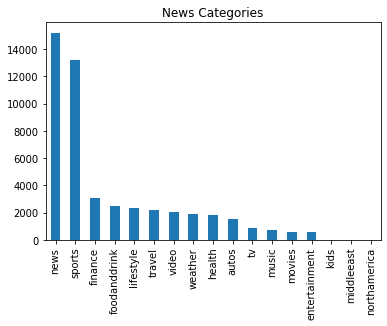

In [27]:
# Distribution of the categories
df_train.category.value_counts().plot.bar(title="News Categories");

In [28]:
# Choose top interesting categories
chosen_articles = [
    "sports",
    "finance",
    "foodanddrink",
    "health",
    "travel",
    "weather",
    "movies",
    "music",
]

In [29]:
display(df_train.shape)
df_train = df_train[df_train.category.isin(chosen_articles)]

(48616, 2)

In [30]:
display(df_test.shape)
df_test = df_test[df_test.category.isin(chosen_articles)]

(40395, 2)

#### Take a smaller subset of data if `QUICK_RUN = True`  

Depending on the parameters set above, we may or may not be sampling a smaller set of data for further downstream processing.   

In [31]:
# shuffle and reset index
df_train = df_train.sample(frac=TRAINING_FRAC).reset_index(drop=True)
df_test = df_test.sample(frac=TEST_FRAC).reset_index(drop=True)

In [32]:
display(df_train.head(10))
display(df_train.shape)

,category,text
0,travel,Tacoma restaurant blaze investigated as arsonI...
1,finance,No degree? No problem! These jobs will still p...
2,travel,Plane Crashes At Florida Air ShowA plane crash...
3,sports,President Trump planning to attend Alabama-LSU...
4,sports,Pacers exploring trade as Sabonis extension ta...
5,finance,"Lawsuit accuses Turner, council of shortchangi..."
6,sports,Vela leads LAFC past Zlatan's Galaxy for 1st p...
7,sports,Harper happy for Nationals: 'Jealousy isn't go...
8,sports,More efficient pass rush the key to Bucs defen...
9,sports,"Kuchar grouped with Ancer, Finau at MayakobaDe..."


(5217, 2)

In [33]:
display(df_test.head(10))
display(df_test.shape)

,category,text
0,sports,"Watch: Aaron Rodgers, Allen Lazard make 'MNF' ..."
1,sports,Rafael Nadal Slams Reporter After Being Asked ...
2,sports,Chargers melt down when home field turns into ...
3,foodanddrink,Oklahoma Supreme Court looks at bill that coul...
4,health,The Rock's Gnarly Palm Is a Testament to Life ...
5,movies,Inside Liam Hemsworth and Maddison Brown's PDA...
6,finance,Time to start your student loan payments? Here...
7,sports,2 women who flashed breasts at World Series ba...
8,foodanddrink,30 Ways You Should Start Planning Your Thanksg...
9,foodanddrink,Get seafood and more at Argyle Forest's new Ro...


(4292, 2)

The examples in the dataset are grouped into 8 news article category

In [34]:
df_train[LABEL_COL].value_counts()

sports          2653
finance          606
foodanddrink     501
travel           454
health           372
weather          353
music            140
movies           138
Name: category, dtype: int64

In [35]:
df_test[LABEL_COL].value_counts()

sports          2146
finance          491
foodanddrink     447
health           350
travel           348
weather          284
music            120
movies           106
Name: category, dtype: int64

## Exploratory Data Analysis

### Defining a tokenizer 

Pipeline to remove stop words, urls, punct and lammatize words


In [36]:
# ####################### HELPERS #########################
# from spacy.lang.en import English
# def load_spacy_english_model(name: str = "en_core_web_sm") -> English:
#   """ Load a spacy English model"""
#   assert name.startswith("en"), "[ERROR] - Model returns a Spacy English model."
#   return spacy.load(name) 

# def lemmatize(token: str) -> str:
#   """ Returns lemmatized token """
#   return token.lemma_ 

# def normalize(token: str, do_lemma: bool = True) -> str:
#   """ Normalize and Lemmatize token """
#   return lemmatize(token).lower() if do_lemma else token.lower()

# def is_acceptable_token(token: str) -> bool:
#   """ Checks if a token is acceptable and not punction or url """
#   return (not token.is_punct) & (not token.like_url) & token.is_alpha & (not token.is_stop)

# ####################### END HELPERS #########################


# ## Load Spacy nlp model 
# nlp = load_spacy_english_model()

# def tokenize_doc(doc: str, 
#                  model = nlp) -> List:
#   """ Tokenize a single document """
#   parsed = model(doc)
#   acceptable_tokens = list(filter(is_acceptable_token, parsed))
#   return list(map(normalize, acceptable_tokens))

In [37]:
def better_tokenizer(doc, model=en):
  return [x.lemma_.lower() for x in en(doc) if (x.is_alpha)&
          (not x.like_url)&(not x.is_punct)&(not x.is_stop)]

Creating tokenized representation 


In [38]:
news_data = [better_tokenizer(str(d)) for d in df_train['text']]

In [39]:
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False,min_df=2) 
tfidf = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False,min_df=2)

In [40]:
# **important** just fit on trained: prevents information from test in training 
cv_vecs = cv.fit_transform(news_data).toarray()
tfidf_vecs = tfidf.fit_transform(news_data).toarray()


# get out the vocab (same for tfidf)
vocab = cv.vocabulary_
print("Size of vocab:", len(vocab))

Size of vocab: 9269


In [41]:
display(cv_vecs.shape)
display(tfidf_vecs.shape)

(5217, 9269)

(5217, 9269)

### Top words for each news category articles (Counts and TF-IDF)

In [42]:
# get top x words
top_words = 10


# Getting the correct index for rows in the train dataset. The original index are kept intact and not reset.

categories_rows_indx = []

for category in chosen_articles:
    categories_rows_indx.append((category, df_train.index[df_train['category'] == category].tolist()))

In [43]:
for vectorizer, vecs  in [(cv, cv_vecs), (tfidf, tfidf_vecs)]:
    print(f"Top {top_words} words using {vectorizer.__class__.__name__}")
    for category, indx in categories_rows_indx:    
        # sum counts
        s_sum = vecs[indx].sum(axis=0)
        # sort arguments
        s_sorted = np.argsort(s_sum)
        # print top words
        print(f"{category} category")
        print([vectorizer.get_feature_names()[x] for x in s_sorted[-top_words:]])
    print("\n")

Top 10 words using CountVectorizer
sports category
['sunday', 'night', 'state', 'new', 'win', 'football', 'team', 'season', 'week', 'game']
finance category
['best', 'city', 'trade', 'state', 'company', 'said', 'million', 'year', 'home', 'new']
foodanddrink category
['holiday', 'pizza', 'restaurants', 'chicken', 'recipes', 'thanksgiving', 'restaurant', 'best', 'food', 'new']
health category
['vaping', 'study', 'cancer', 'said', 'says', 'body', 'people', 'weight', 'health', 'new']
travel category
['flight', 'world', 'county', 'best', 'time', 'plane', 'street', 'city', 'said', 'new']
weather category
['tuesday', 'temperatures', 'morning', 'area', 'storm', 'cold', 'said', 'snow', 'fire', 'weather']
movies category
['movies', 'films', 'set', 'star', 'million', 'best', 'trailer', 'new', 'movie', 'film']
music category
['pop', 'band', 'american', 'awards', 'night', 'john', 'new', 'tour', 'country', 'music']


Top 10 words using TfidfVectorizer
sports category
['night', 'patriots', 'state', '

### Analyzing with Topic Modeling

In [44]:
n_components=8

nmf = NMF(n_components=n_components)
lda = LatentDirichletAllocation(n_components=n_components)

# tfidf for nmf
nmf_vecs = nmf.fit_transform(tfidf_vecs)
nmf_words = nmf.components_.T

# count for lda
lda_vecs = lda.fit_transform(cv_vecs)
lda_words = lda.components_.T

Topic model performance


In [45]:
print('NMF Reconstruction err:', nmf.reconstruction_err_)
print('LDA ELBO:', lda.bound_)

NMF Reconstruction err: 71.27100933506841
LDA ELBO: 4772.413427177884


Topic model top 10 words


In [46]:
def display_components(model, word_features, top_display=8):
    # utility for displaying respresentative words per component for topic models
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_words = [word_features[i] for i in top_words_idx]
        print(" ".join(top_words))

In [47]:
print('Displaying top 10 words in each topic using NMF(tfidf): ')
display_components(nmf, tfidf.get_feature_names())

print('\n')

print('Displaying top 10 words in each topic using LDA(CountVectorizer): ')
display_components(lda, cv.get_feature_names())

Displaying top 10 words in each topic using NMF(tfidf): 
Topic 0:
week game nfl season win chiefs lions cowboys
Topic 1:
new fire said city people home year says
Topic 2:
astros world series nationals game houston yankees washington
Topic 3:
football state college michigan school playoff high saturday
Topic 4:
weather snow forecast today cold temperatures winter week
Topic 5:
patriots new england brady tom jets gordon york
Topic 6:
best thanksgiving food recipes cities holiday recipe favorite
Topic 7:
ravens bengals jackson lamar baltimore quarterback cincinnati sunday


Displaying top 10 words in each topic using LDA(CountVectorizer): 
Topic 0:
game new series week astros night world ravens
Topic 1:
state football week season college michigan said coach
Topic 2:
new home best city year food tour time
Topic 3:
patriots new england browns brady said tom bill
Topic 4:
fire county said new school thanksgiving city best
Topic 5:
team game season week eagles points win cowboys
Topic 6:
weat

### PCA Visualization

In [48]:
# get vectors for vocab
glove_vecs = np.zeros(shape=(len(vocab), 300))
for k, v in vocab.items():
    glove_vecs[v] = nlp(k).vector

In [49]:
vec_list = [
            ("CV", cv_vecs),
            ("TFIDF", tfidf_vecs),
            ("NMF", nmf_words),
            ("LDA", lda_words),
            ("Glove", glove_vecs)
           ]

<Figure size 432x288 with 0 Axes>

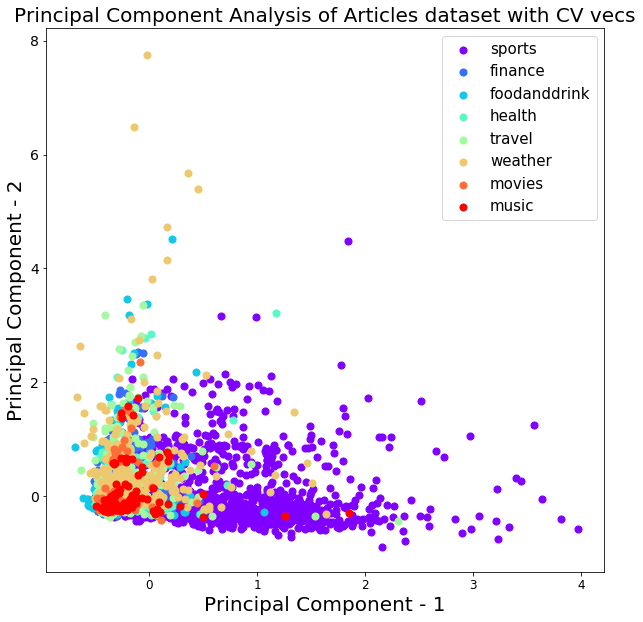

<Figure size 432x288 with 0 Axes>

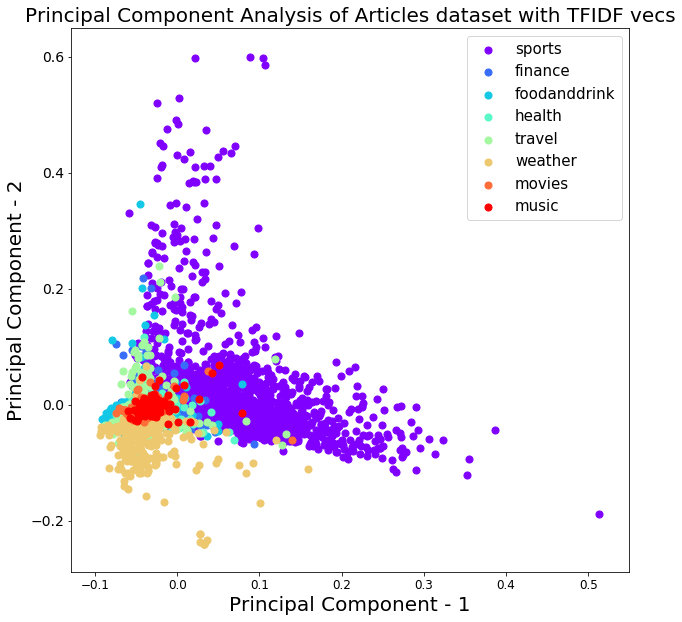

<Figure size 432x288 with 0 Axes>

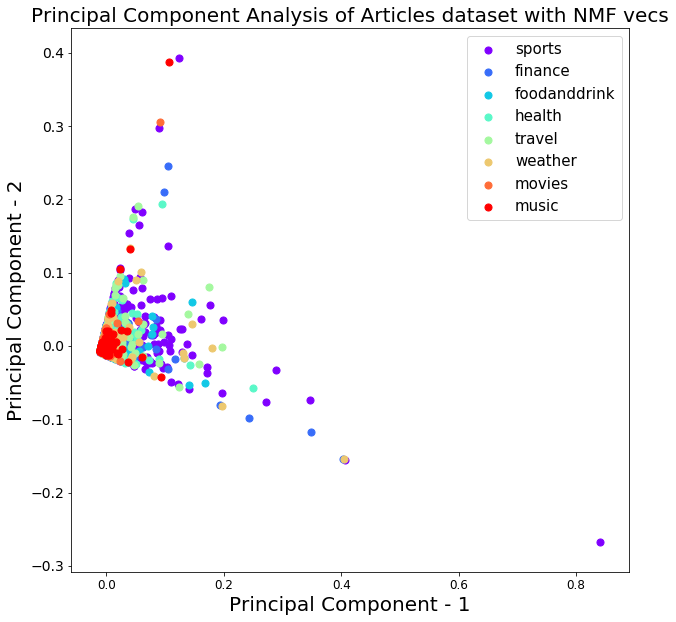

<Figure size 432x288 with 0 Axes>

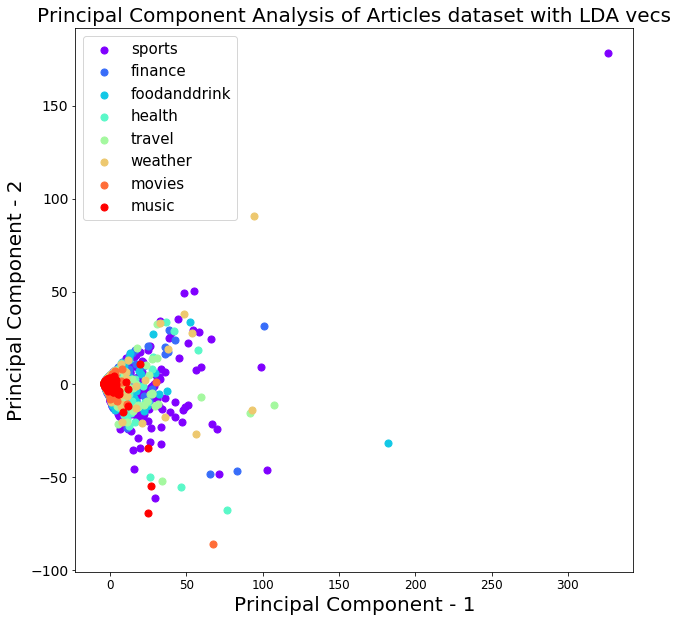

<Figure size 432x288 with 0 Axes>

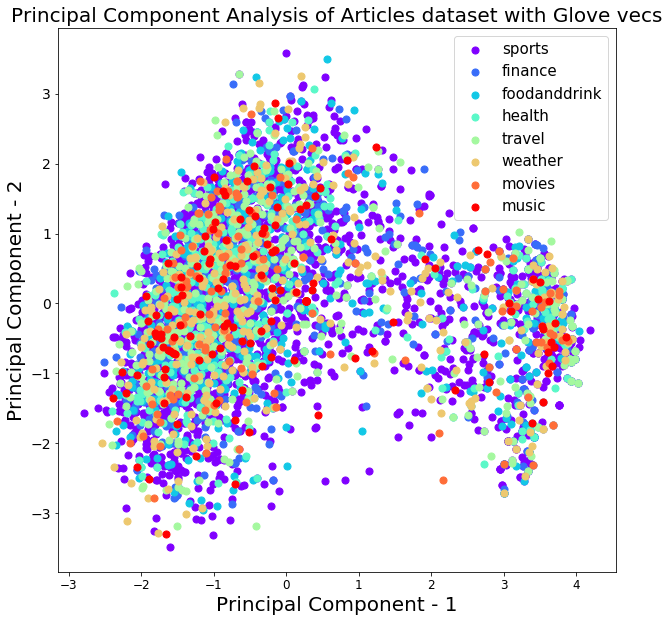

In [50]:
for name, vecs in vec_list:
    pca_plots(df_train, vecs, name, chosen_articles)

##  Fitting SVM models for TFIDF, CV, NMF, LDA and Glove vectors

Data prep for SVM Training


In [ ]:
X_train_text = df_train['text']
y_train = df_train['category']
X_test_text = df_test['text']
y_test = df_test['category']

Initialize models/vectorizers to use


In [ ]:

n_components=8

svc = LinearSVC()
tfidf = TfidfVectorizer(tokenizer=better_tokenizer, min_df=2)
cv = CountVectorizer(tokenizer=better_tokenizer, min_df=2)
nmf = NMF(n_components=n_components)
lda = LatentDirichletAllocation(n_components=n_components)

Generate different vectors

In [ ]:
# TFIDF featureset
tfidf_train = tfidf.fit_transform(X_train_text)
tfidf_test = tfidf.transform(X_test_text)

# CV featureset
cv_train = cv.fit_transform(X_train_text)
cv_test = cv.transform(X_test_text)


# NMF featureset
nmf_train = nmf.fit_transform(tfidf_train)
nmf_test = nmf.transform(tfidf_test)


# Glove featureset
glove_train = np.concatenate([nlp(doc).vector.reshape(1, -1) for doc in X_train_text])
glove_test = np.concatenate([nlp(doc).vector.reshape(1, -1) for doc in X_test_text])

### Fit SVC with all the vectors

In [ ]:
# fit/predict on full dataset
svc = LinearSVC(max_iter=10000)
for pair in [(tfidf_train, tfidf_test, "tfidf"),
             (cv_train, cv_test, "cv"),
            (nmf_train, nmf_test, "nmf"),
            (glove_train, glove_test, "glove"),
            ]:
    with Timer() as t:
        svc.fit(pair[0], y_train)
    train_time = t.interval / 3600
    preds_test = svc.predict(pair[1])
    preds_train = svc.predict(pair[0])
    acc_train = accuracy_score(y_train, preds_train)
    acc_test = accuracy_score(y_test, preds_test)
    

    class_report = classification_report(y_test, preds_test, output_dict=True)

    MODEL_RESULTS[pair[2]] = {
        "Test Set Accuracy": acc_test,
        "f1-score": class_report["macro avg"]["f1-score"],
        "time(hrs)": train_time,
    }
    
    print(f"{pair[2]} Train acc : ",acc_train)
    print(f"{pair[2]} Test acc : ",acc_test)
    print("\n")

### Evaluation classical method results  

At this point we can evaluate the accuracy and f1 scores obtained from running some of the classical NLP approaches for this type of scenario.  

In [ ]:
pd.DataFrame(MODEL_RESULTS).transpose()

---

## Evaluation of Transformer Based Models  
So far, it seems that `LinearSVC`, using `TfIdfVectorizer` performs the best. Now, we would like to compare the performance of this classical method, on various tokenization and vectorization strategies tried out earlier, against some State-Of-The-Art (SOTA) transformer based models that can be used in sequence classification problems.  

For this, we will be using PyTorch and leveraging Hugging Face's implementation of these transformer based models.  

### Selecting Pretrained Models
 Recently, we have experience a break-through in the world of NLP. There is abundant data and compute is a lot better to use. This has given birth to transformer models like starting from [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805) (Devlin et. al). The challenge is that these transformer based models are training with a lot of parameters, making it too large to use in production. Operationalization costs for these large models  on-the-edge and/or under constrained computational training or inference budgets remains challenging.    
 
Transfer Learning, a concept borrowed from Computer Vision, can now be applied on text; leading to smaller models, with similar architecture as their teacher models, that still have great performances. Transfer learning from very large pre-trained models has become more prevalent in Natural Language Processing (NLP). 

 Several distilled pretrained models have been made available by [Hugging Face](https://github.com/huggingface/transformers). some of these models can be used for text/sequence classification. We will be using `distilBert, Roberta` and `XLNet` because of their size compared to other larger transformer models.  
 
- [DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html) is a small, fast, cheap and light Transformer model trained by distilling Bert base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of Bert’s performances as measured on the GLUE language understanding benchmark. 

- [RoBERTa](https://huggingface.co/transformers/model_doc/roberta.html) was proposed in [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692) (Liu et.al). It is based on Google’s BERT model released in 2018. RoBERTa builds upon BERT, modifying key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.  

- [XLNet](https://huggingface.co/transformers/model_doc/xlnet.html) was proposed in [XLNet: Generalized Autoregressive Pretraining for Language Understanding](https://arxiv.org/abs/1906.08237) (Yang et. al). XLnet is an extension of the Transformer-XL model pre-trained using an autoregressive method to learn bidirectional contexts by maximizing the expected likelihood over all permutations of the input sequence factorization order.  



### Target Label Pre-processing and Encoding

Let's start first by encoding the target label in the format the transformer models can use. For this we use the `LabelEncoder` from `skLearn` to tranform our target article labels. 

`LabelEncoder` encodes target labels with value between 0 and $n_classes-1$.

> **NOTE:** `LabelEncoder` should be used to transform and encode just the target values.

In [ ]:
label_encoder = LabelEncoder()
df_train[LABEL_COL] = label_encoder.fit_transform(df_train[LABEL_COL])
df_test[LABEL_COL] = label_encoder.transform(df_test[LABEL_COL])

Let's see what our target labels now look like.

In [ ]:
display(df_train[LABEL_COL])

In [ ]:
num_labels = len(np.unique(df_train[LABEL_COL]))
print("Number of unique labels: {}".format(num_labels))
print("Number of training examples: {}".format(df_train.shape[0]))
print("Number of testing examples: {}".format(df_test.shape[0]))

Our data is now pre-processed, we have our train and test data splits, encoded our target labels. At this point, we are ready to start fine-tuning our data to the models.  

## Model Fine-tuning with News Article Data

For this part, we choose an engineering design that abstracts the model fine-tuning code into reusable components that make it easy to build `sklearn` type of pipelines.  

The decision to approach it this way was to make the code more readable, less bloated here on the notebook, and also production ready to be used in future projects.    

Below we go into details describing the various classes we have defined and created.  

### Wrapper Code Components - Overview and Description of the Code Classes

Our wrappers make it easy to fine-tune different models in a unified way, hiding the preprocessing details that are needed before training. In this example, we're going to select the following models, listed below, and use the same piece of code to fine-tune them on our articles classification task. 

> **NOTE:** - Some models were pretrained on multilingual datasets and can be used with non-English datasets as well. Leveraging the Hugging Face `AutoModels`, it's easy to expand the scope of the models supported with our wrappers.  


#### Code definitions  

1. **DownloadMindDataset**: This is a utility class we wrote that handles downloading of the MIND dataset, if it does not exist, extracts the data, does some initial processing and returns a tuple of train and test dataframes. The class has the following static methods:  
    - `download_from_url`: This method is responsible for downloading the MIND dataset from Azure Storage Blobs. It downloads a URL to a temporary file for further processing.   
    
    - `process_and_load_dfs`: Download MIND from a URL, process it and both training and test dataframes

1. **ArticleTransformer**: This is a transfomer base class that abstracts all the functionality expected from a PyTorch transfomer models. It provides abstractions for setting up model parameters like saving and loading a trained checkpoint, creating a default optimizer and scheduler, setting up the model seed, parallelizing and distributing the tensors to all the GPUs available and more. Most importantly, it abstracts the following methods that will be have a concrete implementation in classes that inherit this:
    - `fine_tune`
    - `predict`

1. **ArticleClassifier**:  This inherits from the **ArticleTransfomer** class. It implements the following methods based
    - `fit`: This is a wrapper, and implementation of the `fine_tune` function from the parent class. This function helps to fine-tune a pre-trained sequence classification model.
    - `predict`: This function helps to score a dataset using a fine-tuned model and a given dataloader.

1. **ArticleClassificationDataProcessor**: This class for implements functionality for preprocessing the article classification data. The following are the major methods
    - `create_dataset_from_dataframe`: This takes a Pandas dataframe, processes it and converts it into a PyTorch dataset.
    - `create_dataset_from_dataframe`: This takes a PyTorch dataset, processes it and converts it into a PyTorch dataloader.  
    - `get_inputs`: This creates an input dictionary, given a model name, which contains the input ids, segment ids, masks, and labels. The labels are only returned when `train_mode` is True.
    - `text_transform`: This function is used for sequence classification. The function can be passed to a map-style PyTorch DataSet.

1. **ArticleClassificationDataSet**: This inherits from PyTorch Dataset and creates a dataset for a single article/sequence classification tasks.


> **NOTE:** All code wrappers and utilities can be found under the [src/common](./common) folder.  

As a reminder, the following are the models we will be fine-tuning for this project

In [ ]:
print(MODEL_NAMES)

For each pretrained model, we preprocess the data, create PyTorch datasets from dataframes, convert those datasets into dataloaders. Then we fine-tune the classifier, using the dataloaders, score on the test set, and store the evaluation results.  

In [ ]:
for name in tqdm(MODEL_NAMES, disable=True):

    # preprocess steps
    # 1. Dataframe --> PyTorch Dataset
    # 2. Dataset --> PyTorch Dataloader
    processor = ArticleClassificationDataProcessor(
        model_name=str(name),
        to_lower=name.endswith("uncased"),
        batch_size=BATCH_SIZE, 
        num_gpus=NUM_GPUS,
        cache_dir=CACHE_DIR
    )
    
    # Defining training artifacts from the processor
    train_dataset = processor.create_dataset_from_dataframe(df_train, TEXT_COL, LABEL_COL, max_len=MAX_LEN)
    train_dataloader = processor.create_dataloader_from_dataset(train_dataset, shuffle=True)
    
    # Defining test artifacts from the processor
    test_dataset = processor.create_dataset_from_dataframe(df_test, TEXT_COL, LABEL_COL, max_len=MAX_LEN)
    test_dataloader = processor.create_dataloader_from_dataset(test_dataset, shuffle=False)

    # fine-tune the classifier using our article dataloader
    classifier = ArticleClassifier(model_name=name, num_labels=num_labels, cache_dir=CACHE_DIR)
    with Timer() as t:
        classifier.fit(
            train_dataloader, num_epochs=NUM_EPOCHS, num_gpus=NUM_GPUS, verbose=False,
        )
    # compute amount of time to run epoch
    train_time = t.interval / 3600

    # predict on the test set
    preds = classifier.predict(test_dataloader, num_gpus=NUM_GPUS, verbose=True)

    # evaluate the model accuracy 
    accuracy = accuracy_score(df_test[LABEL_COL], preds)
    class_report = classification_report(
        df_test[LABEL_COL], preds, target_names=label_encoder.classes_, output_dict=True
    )

    # save results
    MODEL_RESULTS[name] = {
        "Test Set Accuracy": accuracy,
        "f1-score": class_report["macro avg"]["f1-score"],
        "time(hrs)": train_time,
    }

## Evaluate

Finally, we report the accuracy and F1-score metrics for each model, as well as the fine-tuning time in hours.  

> For the sake of time, matching up to the classical method and computation cost, we've decided to fine-tune the model on just a single epoch. We already observe very good accuracy, however, please modify `NUM_EPOCHS` to increase the number of epochs.

In [ ]:
pd.DataFrame(MODEL_RESULTS).transpose()

## Conclusion  

In conclusion, this notebook walks us through various NLP techniques; from classically to State-Of-The-Art transformer models.  


### Data and Results
We used the Microsoft MIND at Work News Recommendation dataset to fine-tune news article classification. We see that just for a single epoch, the `xlnet-base-cased` performs the best on the small dataset from MIND at Work. This confirms our hypothesis, that transformer models are indeed SOTA and should outperform classical methods for text classification.  


### Code 
We created reusable wrappers of code that makes it easy to abstract the data processing, tokenization, vectorization and fine-tuning of models. Our wrappers make it easy to expand to other models supported by the Hugging Face PyTorch library for single sentence sequence classification.  

### Future Work  

1. Build a news recommendation engine that uses our fine-tuned models  

1. Plug in our wrappers and make it easy to switch between various fine-tuned models for text classification  

1. Create a UI component and application  


### References  

1. [Microsoft MIND at work:](https://blogs.msn.com/mind-at-work-news-recommendation-challenge-for-researchers/)  News recommendation competition open to researchers and publishers

1. [Microsoft NLP Recipes](https://github.com/microsoft/nlp-recipes)

1. [Hugging Face Transformers](https://github.com/huggingface/transformers)